# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 9. Байесовские классификаторы.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds22_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 30 баллов
* Задача 2 &mdash; 28 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.2, palette='Set2')
%matplotlib inline

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [ ]:
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

Перед выполнением задания обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/estimators.html">ноутбук</a> с занятия по оценкам параметров.

---
### Задача 1.

На занятии мы уже научились классифицировать текстовые сообщения на нормальные и спам. Теперь перед вами стоит более серьезная задача &mdash; построить систему, автоматически классифицирующую поступающие новостные сюжеты на несколько заранее заданных категорий.
 


Перед выполнением задачи обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/bayes_classification.html">ноутбук</a> с занятия по классификации.

---

С помощью кода ниже загрузите встроенные в `sklearn` <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups">данные</a>, в которых представлены различные новостные сюжеты, разделенные на 20 тематических групп.

In [ ]:
# удаляем заголовки и подписи
remove = ('headers', 'footers')
# зафиксируем зерно случайности
random_state = 42

# Извлекаем обучающую и тестовую части перемешивая случайным образом
data_train = fetch_20newsgroups(
    subset='train', shuffle=True, random_state=random_state, remove=remove
)
data_test = fetch_20newsgroups(
    subset='test', shuffle=True, random_state=random_state, remove=remove
)

In [ ]:
len(data_train['data'])

11314

In [ ]:
data_train_and_validate_df = pd.DataFrame(data_train, columns=['data', 'target'])

In [ ]:
data_train_and_validate_df

,data,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14
...,...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13
11310,"I have a (very old) Mac 512k and a Mac Plus, b...",4
11311,I just installed a DX2-66 CPU in a clone mothe...,3
11312,In article <1qkgbuINNs9n@shelley.u.washington....,1


In [ ]:
data_train_df, data_validate_df = train_test_split(data_train_and_validate_df, train_size=0.8, shuffle=True, random_state=42)

Посмотрим на какое-нибудь сообщение

In [ ]:
print(data_train['data'][21])

In article <1993Apr20.151818.4319@samba.oit.unc.edu> Scott.Marks@launchpad.unc.edu (Scott Marks) writes:
>>And of course, Mike Ramsey was (at one time) the captain in Buffalo prior to
>>being traded to Pittsburgh.  Currently, the Penguins have 3 former captains
>>and 1 real captain (Lemieux) playing for them.  They rotate the A's during the
>>season (and even the C while Mario was out).  Even Troy Loney has worn the C
>>for the Pens.
>

I think that Mike Foligno was the captain of the Sabres when he
got traded to the Leafs. Also, wasn't Rick Vaive the captain of
the Leafs when he got traded to Chicago (with Steve Thomas for
Ed Olcyzk and someone). Speaking of the Leafs, I believe that
Darryl Sittler was their captain (he'd torn the "C" off his
jersey but I think he re-claimed the captaincy later on) when he
was traded to the Flyers.

Oh yeah, of course, Gretzky was the captain of the Oilers before
he was traded wasn't he? 


Индекс тематической группы для каждого сообщения

In [ ]:
data_train['target']

array([7, 4, 4, ..., 3, 1, 8])

Названия тематических групп

In [ ]:
data_train['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

С помощью методов, изученных в рамках нашего курса, постройте классификатор новостных сюжетов на тематические группы. При построении классификатора **запрещено пользоваться тестовой выборкой**. Для настройки классификатора, например, выбора оптимальных гиперпараметров, можно разделить обучающую выборку на две части &mdash; непосредственно обучающую и валидационную. Первую часть использовать для непосредственного обучения, а вторую &mdash; для настройки, пытаясь по ней оптимизировать качество.

In [ ]:
def targ_name(number):
  return data_train['target_names'][number]

In [ ]:
data_train_df['target_name'] = data_train_df['target'].apply(targ_name)

In [ ]:
data_train_df

,data,target,target_name
6606,Nikon FM-2n with 50 mm Nikkor and accessories ...,6,misc.forsale
10808,"Heres the life of St. MAria Goretti, posted wi...",15,soc.religion.christian
10683,kwfinken@pooh.harpo.uccs.edu (Kevin W. Finkenb...,15,soc.religion.christian
2089,In article <1993Apr16.155637.15398@oracle.us.o...,2,comp.os.ms-windows.misc
4026,"In article <114152@bu.edu>, lcai@acs2.bu.edu s...",3,comp.sys.ibm.pc.hardware
...,...,...,...
11284,> > \n> > Doesn't a 1 MB SIMM have about 1024 ...,4,comp.sys.mac.hardware
5191,In article <1993Apr6.195710.24227@cs.tulane.ed...,7,rec.autos
5390,livesey@solntze.wpd.sgi.com (Jon Livesey) writ...,0,alt.atheism
860,In article <C5HIyr.327@news.cso.uiuc.edu> eshn...,17,talk.politics.mideast


In [ ]:
counts_train = data_train_df.value_counts(data_train_df['target_name'], sort=True)
counts_train

target_name
rec.sport.baseball          495
rec.sport.hockey            492
comp.windows.x              487
comp.graphics               480
soc.religion.christian      477
sci.electronics             477
rec.motorcycles             476
misc.forsale                476
comp.os.ms-windows.misc     476
sci.med                     475
sci.crypt                   470
comp.sys.ibm.pc.hardware    467
sci.space                   466
talk.politics.mideast       462
rec.autos                   455
comp.sys.mac.hardware       452
talk.politics.guns          425
alt.atheism                 383
talk.politics.misc          358
talk.religion.misc          302
dtype: int64

In [ ]:
len(counts_train)

20

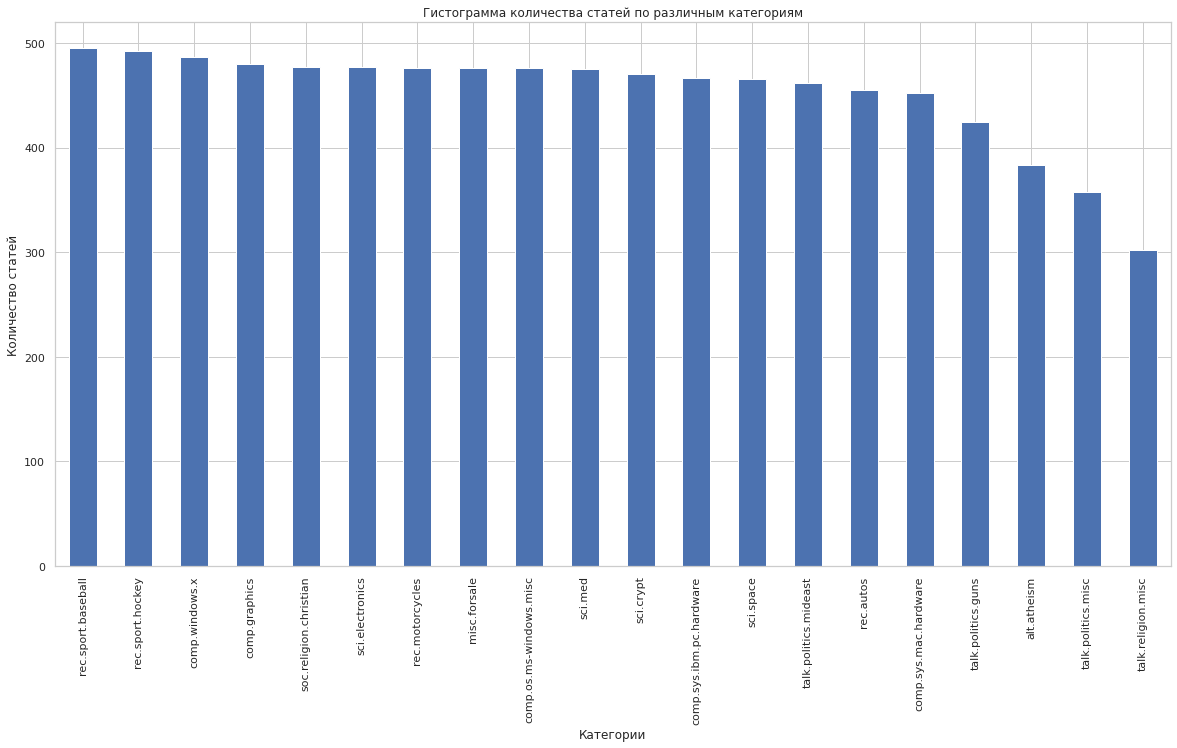

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(style='whitegrid')
counts_train.plot(kind='bar')
plt.xlabel('Категории')
plt.ylabel('Количество статей')
plt.title('Гистограмма количества статей по различным категориям')
plt.show()

*Видим, что, в целом, дисбаланса классов нет.*

In [ ]:
from collections import Counter

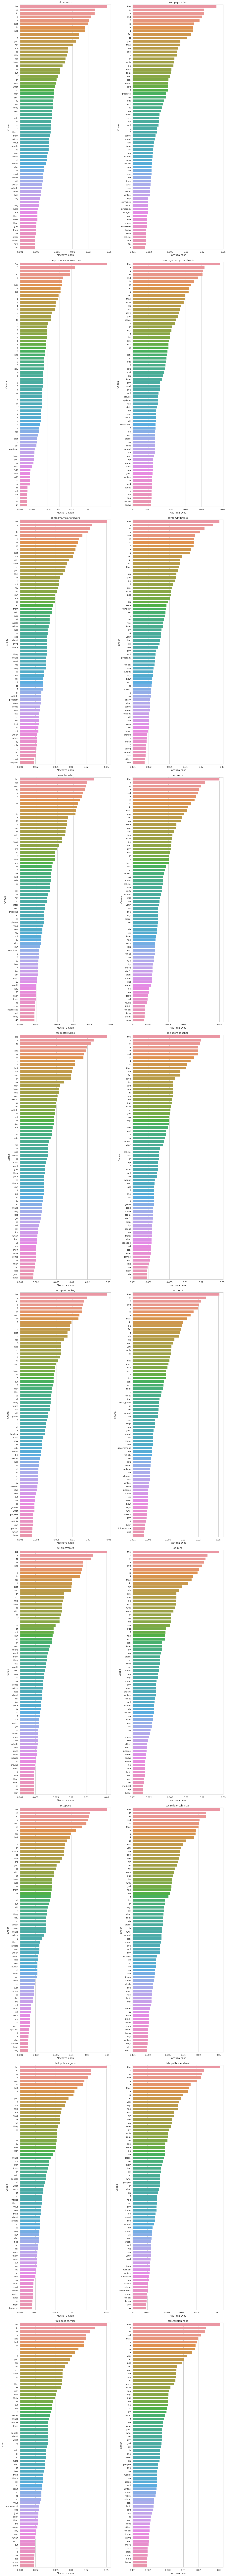

In [ ]:
sns.set(style='whitegrid')

# метки сетки по оси икс
labels = [1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2]

plt.figure(figsize=(16, 18*10))

replaced_symbols = [' ', '>', ':', '.', ',', '"', '!', '?', '@', '#', '$', '%', '^', '&', ';', '<', '_', '--', '---', '/', '=', '+', '(', ')', '[', ']', '|']

# для каждого класса
for i, label in enumerate(data_train['target_names']):
    # извлечем все сообщения и склеим их

    all_words = ' '.join(data_train_df[data_train_df['target_name'] == label]['data']).lower()
    for symbol in replaced_symbols:
      all_words =  all_words.replace(symbol, ' ')
    all_words = all_words.split()
    # общее количество слов в этом классе
    words_count = len(all_words)

    # посчитаем встречаемость каждого слова и вернем топ-70
    counts = Counter(all_words).most_common(70)
    counts = pd.DataFrame(counts, columns=['word', 'count'])

    plt.subplot(1 * 10, 2, i+1)
    sns.barplot(y=counts['word'], x=counts['count']/words_count)
    plt.xscale('log')
    plt.xlabel('Частота слов')
    plt.ylabel('Слова')
    plt.title(label)
    plt.xticks(labels, labels)
    
plt.tight_layout()

*Может быть, длина статьи - неплохой признак? Проверим это.*

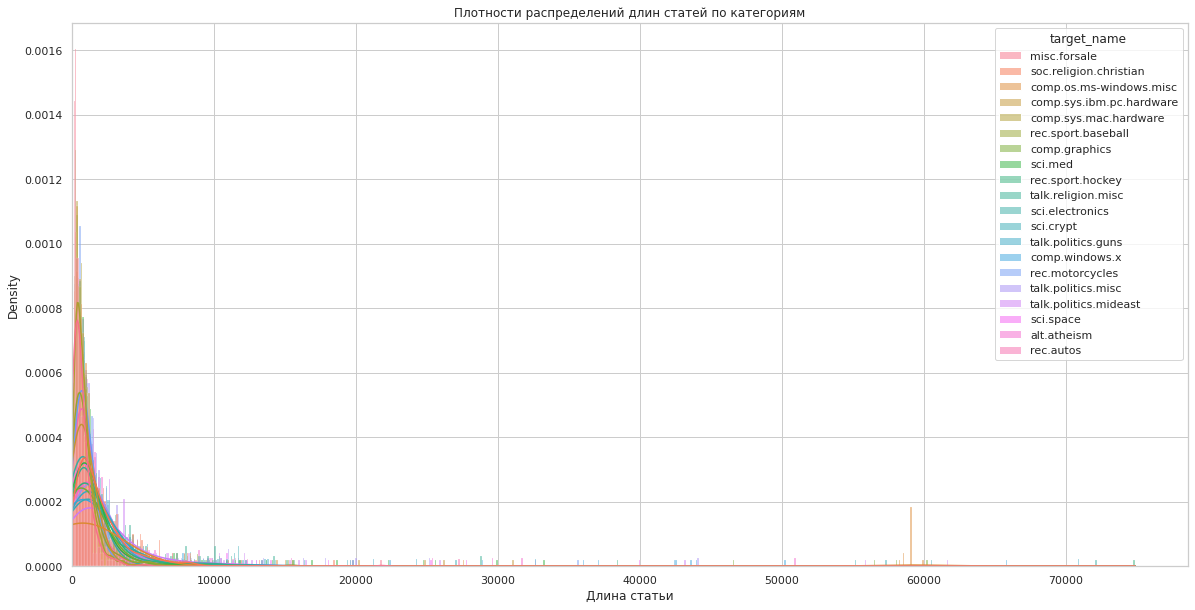

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(style='whitegrid')
sns.histplot(x=data_train_df['data'].apply(len), 
             hue=data_train_df['target_name'], stat='density', 
             kde=True, common_norm=False,
             kde_kws=dict(gridsize=1000))
plt.xlabel('Длина статьи');
plt.title('Плотности распределений длин статей по категориям')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

*Посмотрим посмотрим на гистограмму без учёта выбросов по длине статьи:*

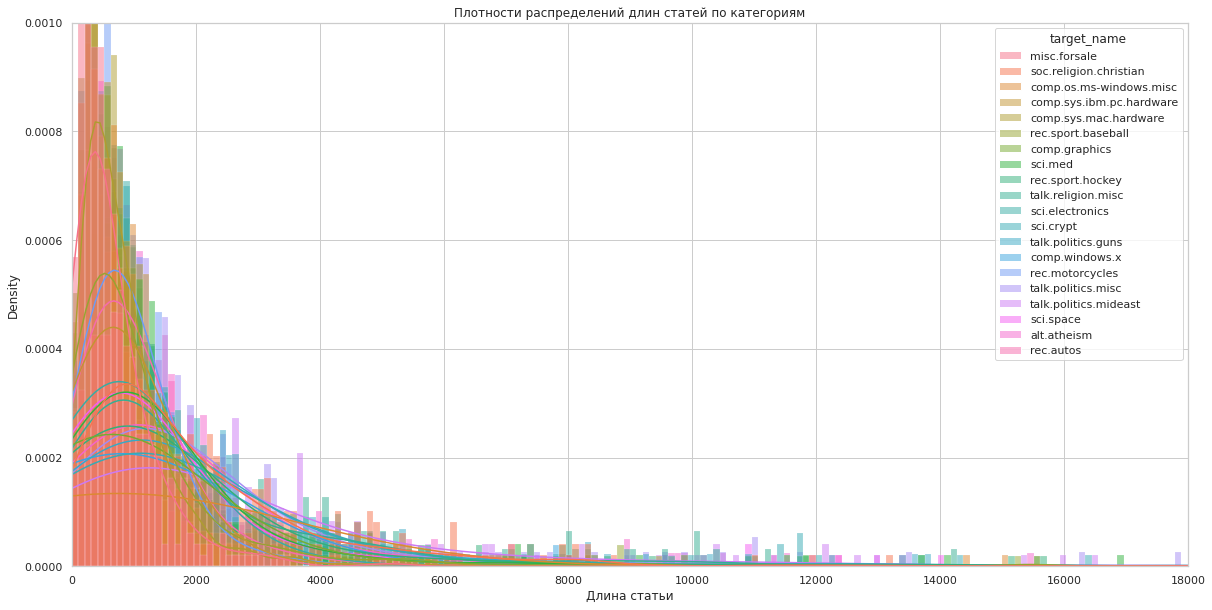

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(style='whitegrid')
sns.histplot(x=data_train_df['data'].apply(len), 
             hue=data_train_df['target_name'], stat='density', 
             kde=True, common_norm=False,
             kde_kws=dict(gridsize=1000))
plt.xlabel('Длина статьи');
plt.title('Плотности распределений длин статей по категориям')
plt.xlim(0,18000)
plt.ylim(0, 0.0010)
plt.show()

*Видим, что длина статьи - не очень хороший признак, поэтому не будем его использовать.*

*Создадим "мешок слов" - некоторое специальное представление слов в виде целочисленного вектора с учётом слов, которые, скорее всего, отражают тему статьи (то есть не будем учитывать самые частые слова: артикли, предлоги, вспомогательные глаголы и тд., и не будем учитывать совсем уж редкие слова).*

In [ ]:
vectorizer = CountVectorizer(min_df=0.0020, max_df=0.0487)
vec_data_train = vectorizer.fit_transform(data_train_df['data']).toarray()

In [ ]:
print(len(vectorizer.get_feature_names()))
print(vectorizer.get_feature_names())

6689
['00', '000', '01', '02', '03', '04', '040', '05', '06', '07', '08', '09', '100', '1000', '101', '102', '1024', '1024x768', '103', '104', '105', '106', '107', '108', '109', '10th', '11', '110', '111', '112', '113', '114', '115', '117', '118', '119', '12', '120', '1200', '121', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '14', '140', '1400', '141', '144', '145', '146', '147', '149', '150', '1500', '151', '152', '155', '157', '158', '160', '161', '165', '16mb', '17', '170', '172', '175', '18', '180', '19', '1914', '1919', '192', '1920', '1948', '1960', '1964', '1967', '1968', '1970', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '198', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '199', '1990', '1991', '1992', '1993apr12', '1993apr13', '1993apr14', '1993apr15', '1993apr16', '1993apr17', '1993apr18', '1993apr19', '1993apr2', '1993apr20', '1993apr21', '1993apr22', '1993apr3', '199

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(vec_data_train[:5])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


*Применим те же преобразования данных к валидационной и тестовой выборкам.*

In [ ]:
data_validate_df['target_name'] = data_validate_df['target'].apply(targ_name)
data_validate_df

,data,target,target_name
7492,Could someone please post any info on these sy...,4,comp.sys.mac.hardware
3546,In article <1993Apr6.040254.8443@cs.brown.edu>...,2,comp.os.ms-windows.misc
5582,"5.25"" Internal Low density disk drive.\n\nMono...",6,misc.forsale
4793,"Hi,\n\nIn Canada, any gun that enters a Nation...",16,talk.politics.guns
3813,In article <120666@netnews.upenn.edu> kkeller@...,10,rec.sport.hockey
...,...,...,...
7930,Brad Banko writes:\n>While running the MS Quic...,2,comp.os.ms-windows.misc
715,"In a previous article, mhsu@lonestar.utsa.edu ...",15,soc.religion.christian
10940,In article <C5qIv3.H0o.1@cs.cmu.edu> nickh@CS....,14,sci.space
8422,Re: More on Gun Buybacks\n\nThe Denver buy bac...,16,talk.politics.guns


In [ ]:
data_test_df = pd.DataFrame(data_test, columns=['data', 'target'])

In [ ]:
data_test_df['target_name'] = data_test_df['target'].apply(targ_name)
data_test_df

,data,target,target_name
0,I am a little confused on all of the models of...,7,rec.autos
1,I'm not familiar at all with the format of the...,5,comp.windows.x
2,"acooper@mac.cc.macalstr.edu (Turin Turambar, M...",0,alt.atheism
3,In article <benali.737307554@alcor> benali@alc...,17,talk.politics.mideast
4,In article <1993Apr21.141259.12012@st-andrews....,19,talk.religion.misc
...,...,...,...
7527,(Henry Spencer) writes:\n> Does anyone have a ...,14,sci.space
7528,In article <1r3jl5$igh@function.mps.ohio-state...,4,comp.sys.mac.hardware
7529,"I sent a version of this post out a while ago,...",9,rec.sport.baseball
7530,I have this kit which includes the following :...,6,misc.forsale


In [ ]:
vec_data_validate = vectorizer.transform(data_validate_df['data']).toarray()

*Здесь будем проверять качество на валидационной выборке и подбирать гиперпараметры (здесь это числа max_df и min_df, а также массив слов и символов stop_words). Конечный результат окажется в ноутбуке и будет далее применён к тестовой выборке.* 

In [ ]:
vec_data_test = vectorizer.transform(data_test_df['data']).toarray()

*Мультиномиальный наивный байес:*

In [ ]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, data_train_df.target_name)

MultinomialNB()

In [ ]:
predictions = multinomial_nb.predict(vec_data_validate)
print(f'Точность: {accuracy_score(data_validate_df.target_name, predictions) :.3}')

Точность: 0.814


*Бернулиевский наивный байес:*

In [ ]:
X_train = (vec_data_train > 0).astype(int)
X_validate = (vec_data_validate > 0).astype(int)
X_test = (vec_data_test > 0).astype(int)

In [ ]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X_train, data_train_df.target_name)

BernoulliNB()

In [ ]:
predictions = bernoulli_nb.predict(X_validate)
print(f'Точность: {accuracy_score(data_validate_df.target_name, predictions) :.3}')

Точность: 0.698


*LDA:*

In [ ]:
LDA_DA = LinearDiscriminantAnalysis()
LDA_DA.fit(vec_data_train, data_train_df.target_name)

LinearDiscriminantAnalysis()

In [ ]:
predictions = LDA_DA.predict(vec_data_validate)
print(f'Точность: {accuracy_score(data_validate_df.target_name, predictions) :.3}')

Точность: 0.519


Посчитайте качество на тестовой выборке.

*Путём эксперимента подобрали некоторые значения гиперпараметров. Проверим их теперь на тестовой выборке.*

*Мультиномиальный байес:*

In [ ]:
predictions = multinomial_nb.predict(vec_data_test)
print(f'Точность: {accuracy_score(data_test_df.target_name, predictions) :.3}')

Точность: 0.734


*Бернулиевский байес:*

In [ ]:
predictions = bernoulli_nb.predict(X_test)
print(f'Точность: {accuracy_score(data_test_df.target_name, predictions) :.3}')

Точность: 0.613


*LDA:*

In [ ]:
predictions = LDA_DA.predict(vec_data_test)
print(f'Точность: {accuracy_score(data_test_df.target_name, predictions) :.3}')

Точность: 0.375


Сделайте выводы.

*1. Эксперимент показал, что признак длины статьи не полезен в этой задаче.*

*2. Эксперимент показал, что максимальной точности удалось досчтичь на наивном мультиномиальном байесовском классификаторе с гиперпараметрами max_df = 0.0487, min_df 0.002, stop_words=[]; При этом на тестовой выборке была достигнута точность $73,4 $ %. Несколько хуже показал себя бернуллиевский наивный байесовский классификатор - удалось достичь точности $61,3 $ % на тестовой выборке (в этом пункте все значения точности посчитаны для вышеуказанных значений гиперпараметров).  Хуже отработал линейный дискриминантный анализ (LDA) - $37,5$ % на тестовой выборке.*

*3. Описанные в пункте 2 результаты в целом ожидаемы. Для наивных байесовских классификаторов мы предполагали, что все признаки (здесь признаками выступают количества слов из некоторого определённого набора vec_data_train) независимы. Ясно, что для большого количества слов в большом тексте это предположение не кажется неестественным. В то же время для LDA предполагается равенство всех матриц ковариаций $\Sigma_1 = \Sigma_2 = ... = \Sigma_k$.*

---
### Задача 2.
Пусть $\mathscr{X} = \mathbb{R}^2$ — пространство признаков, $\mathscr{Y} = \{0, 1\}$ — множество классов. Рассматривается квадратичный дискриминантный анализ. Условное распределение $X$ при условии $Y=k$ равно $\mathcal{N}(a_k, \Sigma_k)$. Приведите примеры таких параметров $a_k, \Sigma_k$ и вероятностей $\mathsf{P}(Y = k)$, при которых разделяющая поверхность является
* гиперболой;
* параболой;
* двумя параллельными прямыми;
* двумя пересекающимися прямыми.

*Пример с гиперболой:*

In [ ]:
m1 = [ [-2, 1], [-2, 2], [-1, 2], [-2, 3], [-1, 2], [3, 5]] 
m1_null = np.array(m1).reshape(6,2)
m1 = np.array(m1).T
cov1 = np.cov(m1)
3 * 10*cov1


array([[113.,  69.],
       [ 69.,  57.]])

In [ ]:
a_1 = np.mean(m1_null,axis=0)
3 * 2* a_1

array([-5., 15.])

In [ ]:
m0 = [[2, 2], [2, 3], [2, 1], [3, 2], [1, 2], [4, 2]]
m0_null = np.array(m0).reshape(6,2)
m0 = np.array(m0).T
cov0 = np.cov(m0)
3*5* cov0


array([[16.,  0.],
       [ 0.,  6.]])

In [ ]:
a_0 = np.mean(m0_null,axis=0)
3 * a_0

array([7., 6.])

In [ ]:
a0_1 = a_0[0]
a0_2 = a_0[1]

a1_1 = a_1[0]
a1_2 = a_1[1]

b0 = cov0[0][0]
c0 = cov0[1][1]
d0 = cov0[0][1]

b1 = cov1[0][0]
c1 = cov1[1][1]
d1 = cov1[0][1]

A = c1/(2*(b1*c1 - d1*d1)) - c0/(2*(b0*c0 - d0*d0))
B = d0/(2*(b1*c1 - d1*d1)) - d1/(2*(b0*c0 - d0*d0))
C = b1/(2*(b1*c1 - d1*d1)) - b0/(2*(b0*c0 - d0*d0))

I2 = A*C - B*B
I2

-7.274395378268495

In [ ]:
A, B, C

(0.040178571428571674, -2.6953125, -0.24107142857142838)

In [ ]:
D = (a0_1*c0 - a0_2*d0)/(2*(b0*c0 - d0*d0)) - (a1_1*c1 - a1_2*d1)/(2*(b1*c1 - d1*d1))
E = (a0_2*b0 - a0_1*d0)/(2*(b0*c0 - d0*d0)) - (a1_2*b1 - a1_1*d1)/(2*(b1*c1 - d1*d1))

In [ ]:
D, E

(3.058035714285715, -0.535714285714286)

In [ ]:
a0 = a_0
a1 = a_1

In [ ]:
pi0 = 6/12
pi1 = 6/12
alpha0 = np.log(pi0) - (1/2) * np.log(np.linalg.det(cov0)) + (1/2) * (a0.T @ np.linalg.inv(cov0) @ a0)
alpha1 = np.log(pi1) - (1/2) * np.log(np.linalg.det(cov1)) + (1/2) * (a1.T @ np.linalg.inv(cov1) @ a1)

In [ ]:
F = alpha0 - alpha1

In [ ]:
I3 = A*C*F + B*E*D + B*E*D - C*D*D - E*E*A - F*B*B
I3

17.883923996135355